## (Task 1) Gathering Retail Data

For this task, I have used the data about the average price of Avocados calculated using nationwide sales data. This data is available on the [website](https://www.hassavocadoboard.com/retail/volume-and-price-data) of the Hass Avocado Board.

It contains region-wise, as well as nation-wide data regarding the sale and the prices of avocados. I have considered the cumulative nationwide data for transactional analysis, and the regional data for statistical and exploratory analysis.

### Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (12, 5)
# plt.rcParams['font.size'] = 14
# plt.style.use("fivethirtyeight")
import glob
import os
import warnings
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import autopep8
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import sqlite3
import seaborn as sns
sns.set_style("dark")

### Importing Data and Combining CSV Files
The dataset is located in the `data` folder, with the CSV files pertaining to yearwise data for conventional avocados in `data/conventional` folder, and those pertaining to organic in `data/organic`.

In the following cells, I'll concatenate the yearwise data for conventional avocados for the years 2016, 2017, and 2018 into one dataframe.

In [2]:
path = 'data/Conventional'
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
conventional_df = pd.concat(df_from_each_file, ignore_index=True)

#### Converting Dates to pandas datetime format

In [3]:
conventional_df['Date'] = pd.to_datetime(conventional_df['Date'])
conventional_df.set_index('Date', inplace=True)

#### Sorting by date in chronological order

In [4]:
conventional_df = conventional_df.sort_index()

### Doing the same for the Organic dataset

In [5]:
path = 'data/Organic'
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
organic_df = pd.concat(df_from_each_file, ignore_index=True)

In [6]:
organic_df['Date'] = pd.to_datetime(organic_df['Date'])
organic_df.set_index('Date', inplace=True)

In [7]:
organic_df = organic_df.sort_index()

## (Task 3) Sanitizing for missing dates
### Checking the conventional avocado dataset

In [8]:
conventional_df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

Since we didn't find any missing values, we don't need to sanitize it.

### Checking the organic avocado dataset

In [9]:
organic_df.isnull().sum()

AveragePrice    1
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

We find that there's one missing value. We'll now need to sanitize for it.

### Sanitization
Given the nature of the dataset and the fact that only one value is missing, it's appropriate to use **mean imputation** to fill in the missing value. We'll use the pandas `fillna` function to do so. 

In [10]:
organic_df.fillna(organic_df.mean(),inplace=True)

In [11]:
organic_df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

As we can see, there are no more missing values.

## Statistical Analysis (Task 2)

I'll perform Statistical Analysis on the combined dataset containing transaction details for all of the regions in the US. 

In [12]:
combined = pd.read_csv('data/combined.csv')
combined['Date'] = pd.to_datetime(combined['Date'])
combined.set_index('Date',inplace=True)
combined = combined.sort_index()

### First, we get a general idea for the numerical data 

In [13]:
convfilter = combined['type']=='conventional'
conv = combined[convfilter]
conv = conv['AveragePrice']
orgafilter = combined['type']=='organic'
orga = combined[orgafilter]
orga = orga['AveragePrice']

#### For conventional avocados

In [14]:
conv.describe()

count    9126.000000
mean        1.158040
std         0.263041
min         0.460000
25%         0.980000
50%         1.130000
75%         1.320000
max         2.220000
Name: AveragePrice, dtype: float64

#### For organic avocados

In [15]:
orga.describe()

count    9123.000000
mean        1.653999
std         0.363502
min         0.440000
25%         1.420000
50%         1.630000
75%         1.870000
max         3.250000
Name: AveragePrice, dtype: float64

#### I'll now draw a box-plot for the average prices, grouping by region and type

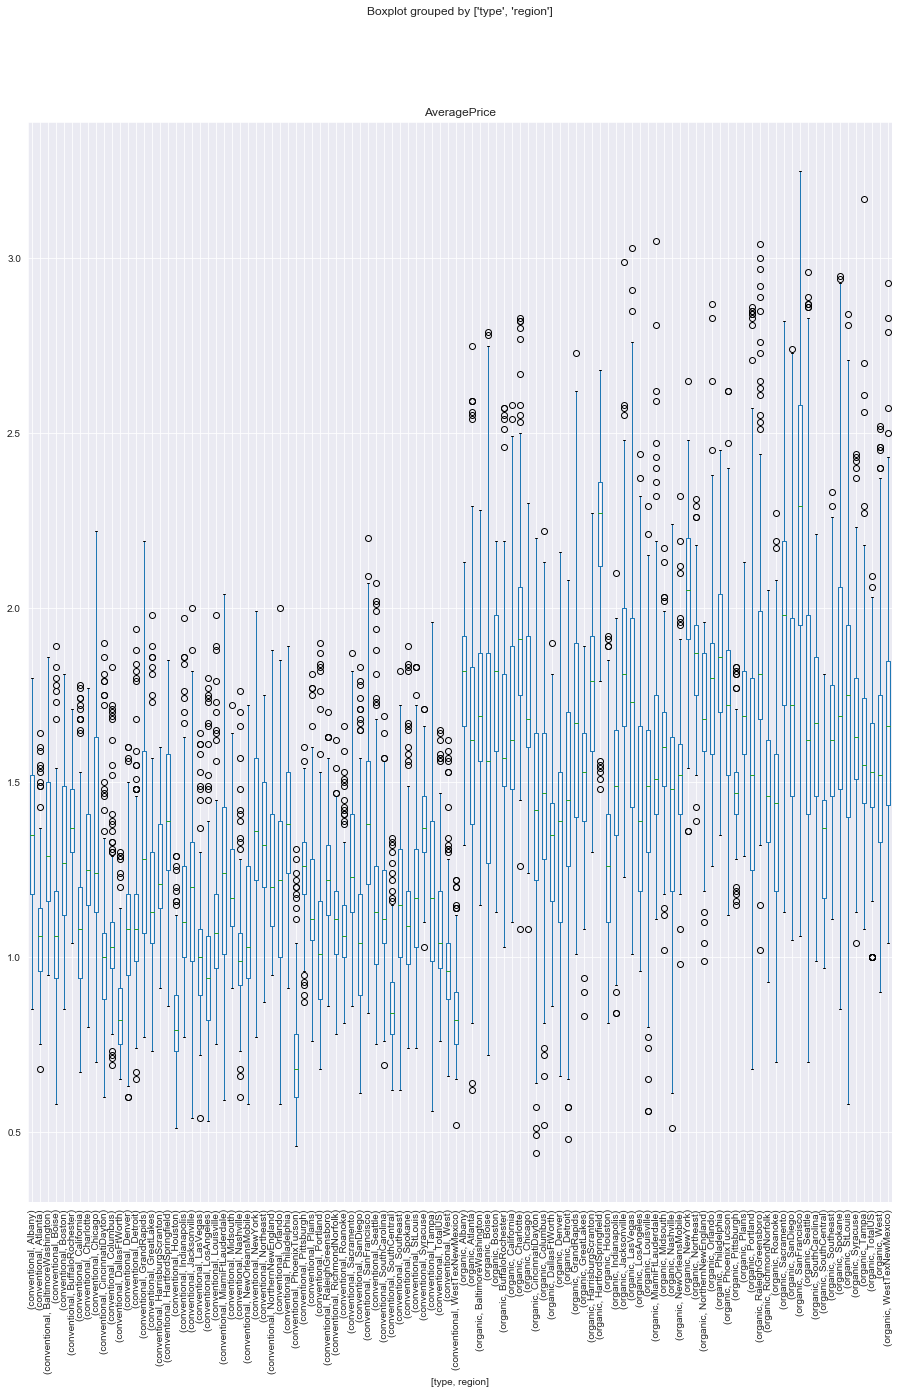

In [16]:
boxplot = combined.boxplot(column=['AveragePrice'], by=['type','region'], figsize=[15,20],rot=90)

### Plotting the average prices of conventional and organic avocadoes

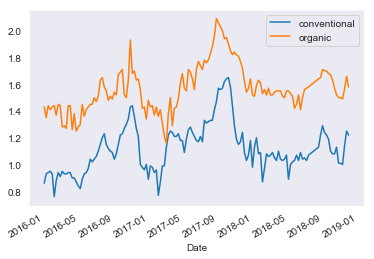

In [17]:
ax = conventional_df.plot(y='AveragePrice', label='conventional')
organic_df.plot(ax=ax,y='AveragePrice', label='organic')

**We observe that the organic avocados are priced higher than the conventional ones.**

**In addition, we see a slightly increasing trend in the prices of the avocados over the years**

**A visual analysis indicates that both organic and conventional avocados follow similar seasonal pricing trends, which is a fact we'll make use of while doing our ARIMA analysis.**

**We'll now observe if this trend is consistent across regions over the years**

The following scatterplot is arranged in increasing order of `AveragePrice` for the year `2018`. 

In [18]:
order = (
    combined[(combined['year']==2018)]
    .groupby('region')['AveragePrice']
    .mean()
    .sort_values()
    .index
)

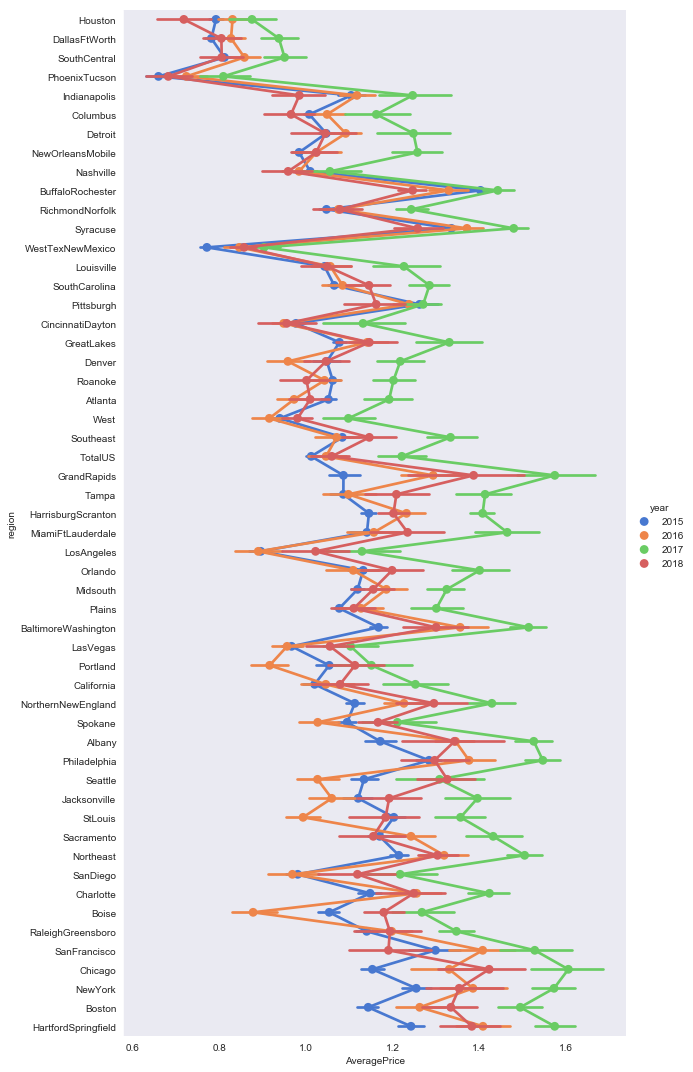

In [19]:
warnings.simplefilter(action='ignore', category=FutureWarning)
g = sns.catplot('AveragePrice','region',data=combined[combined['type']=='conventional'],
                   hue='year',
                kind='point',
                   height=15,
                   aspect=0.6,
                   palette='muted',
                    jitter=True,
                order=order
              )

**We observe that there's an increasing trend in the prices of Avocados in all of the regions in our dataset.**

## Implementing ARIMA, forecasting, storing in database (Tasks 4, 5, & 6)

For convenience, I'll only consider the Organic avocado dataset from here on out. It's trivial to implement the same for the conventional avocado dataset as well.

### Dropping unnececessary columns

In [20]:
organic_df = organic_df.drop(columns = ['Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags'])

### Initializing database
I'll create the connection `con` to the database `Parameters.db`.

In [21]:
con = sqlite3.connect('Parameters.db')

I'll create the cursor `cur` to operate on the database.

In [22]:
cur = con.cursor()

I first check if the table `arimaparams` already exists, if it doesn't I create it. 

In [23]:
tablesql = "CREATE TABLE IF NOT EXISTS arimaparams (p text, d text, q text, mse text)"
cur.execute(tablesql)

I define `insert_sql` to be the SQL query to insert values into the `arimaparams` table.

In [24]:
insert_sql = "INSERT INTO arimaparams (p, d, q, mse) VALUES (?,?,?,?)"

### Implementing grid-wise search and inserting into DB
**(The next cell will take a little bit to execute.)**
In the following cell, I implement a grid-wise search to find the optimal set of values of the ARIMA parameters of `p, d, & q`. 

Function `evaluate_models` serves as the driver. It accepts the dataset, and a set of possible values for p, d, and q as parameters. Then it generates all possible permutations for `(p,d,q)` and passes them onto the `arima_error_calculation` function. This function calculates the error for the ARIMA model with that particular set of `(p,d,q)` values and returns them.

The `evaluate_models` function in turn compares the returned value to the best error value thus far, and if the current value is better than the best it stores that particular configuration.

`evaluate_models` also stores the model parameters into the database `Parameters.db`.

In [25]:
#To evaluate ARIMA model, X = dataframe, arima_order = (p,d,q)
def arima_error_calculation(X, arima_order):
	# split data-sets into training and test
	train_size = int(len(X) * 0.65)
	train = X[0:train_size]
	test = X[train_size:]
	history = [x for x in train]
	# use ARIMA to predict
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate errors
	error = mean_squared_error(test, predictions)
	return error

# grid search for p, d, q values to evaluate ARIMA
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = arima_error_calculation(dataset, order)
					#insert into database
					cur.execute(insert_sql,(p,d,q,mse))
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA with p, d, q%s gives MSE=%.5f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.5f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(organic_df.values, p_values, d_values, q_values)

ARIMA with p, d, q(0, 0, 0) gives MSE=0.00814
ARIMA with p, d, q(0, 0, 1) gives MSE=0.00364
ARIMA with p, d, q(0, 0, 2) gives MSE=0.00316
ARIMA with p, d, q(0, 0, 3) gives MSE=0.00274
ARIMA with p, d, q(0, 1, 0) gives MSE=0.00277
ARIMA with p, d, q(0, 1, 1) gives MSE=0.00297
ARIMA with p, d, q(0, 1, 2) gives MSE=0.00301
ARIMA with p, d, q(0, 1, 3) gives MSE=0.00310
ARIMA with p, d, q(0, 2, 0) gives MSE=0.00537
ARIMA with p, d, q(0, 2, 1) gives MSE=0.00286
ARIMA with p, d, q(1, 0, 0) gives MSE=0.00241
ARIMA with p, d, q(1, 0, 1) gives MSE=0.00256
ARIMA with p, d, q(1, 0, 2) gives MSE=0.00259
ARIMA with p, d, q(1, 1, 0) gives MSE=0.00287
ARIMA with p, d, q(1, 1, 1) gives MSE=0.00305
ARIMA with p, d, q(1, 2, 0) gives MSE=0.00451
ARIMA with p, d, q(1, 2, 1) gives MSE=0.00296
ARIMA with p, d, q(2, 0, 0) gives MSE=0.00251
ARIMA with p, d, q(2, 0, 1) gives MSE=0.00250
ARIMA with p, d, q(2, 0, 2) gives MSE=0.00260
ARIMA with p, d, q(2, 0, 3) gives MSE=0.00267
ARIMA with p, d, q(2, 1, 0) gives 

#### Retrieving model parameters from the database

In [26]:
cur.execute("SELECT * FROM arimaparams")
cur.fetchall()

[('0', '0', '0', '0.00813997638295601'),
 ('0', '0', '1', '0.00363893091418205'),
 ('0', '0', '2', '0.00315633571688102'),
 ('0', '0', '3', '0.00274191056418425'),
 ('0', '1', '0', '0.00277373627603646'),
 ('0', '1', '1', '0.00296562274556327'),
 ('0', '1', '2', '0.00300683679979873'),
 ('0', '1', '3', '0.00310310159377464'),
 ('0', '2', '0', '0.00537464231003507'),
 ('0', '2', '1', '0.00285598696718592'),
 ('1', '0', '0', '0.00241281075119629'),
 ('1', '0', '1', '0.00256267669830949'),
 ('1', '0', '2', '0.00259331296490301'),
 ('1', '1', '0', '0.00287206617015032'),
 ('1', '1', '1', '0.00305405501887583'),
 ('1', '2', '0', '0.0045130918233474'),
 ('1', '2', '1', '0.00295734487681217'),
 ('2', '0', '0', '0.00250740746585089'),
 ('2', '0', '1', '0.00250141888130366'),
 ('2', '0', '2', '0.00260344458452661'),
 ('2', '0', '3', '0.00266716024277305'),
 ('2', '1', '0', '0.0028608728273945'),
 ('2', '1', '1', '0.00302027271586157'),
 ('2', '2', '0', '0.00367721412134054'),
 ('2', '2', '1', '

#### Closing the database connection

In [27]:
con.close()

#### Implementing ARIMA and generating result dataframe

In the following cell, I apply the ARIMA model with the optimal values obtained from the grid-search above. Then I generate the combined dataframe `predicted_df`.

In [28]:
model = ARIMA(organic_df['AveragePrice'], order = (1, 0, 0))
results_ARIMA = model.fit()
predictions = round(results_ARIMA.predict(), 2)
preds = pd.DataFrame(list(zip(list(predictions.index),list(predictions))),columns=['Date',
                                                                                   'PredictedPrice']).set_index('Date')
predicted_df = pd.merge(organic_df[1:], preds, left_index=True, right_index=True)
predicted_df.head()

,AveragePrice,PredictedPrice
Date,,
2016-01-10,1.35,1.44
2016-01-17,1.44,1.37
2016-01-24,1.41,1.45
2016-01-31,1.43,1.43
2016-02-07,1.44,1.44


#### Calculating Errors

I calculate the Mean Squared Error and the Root Mean Squared Error for the ARIMA model.

In [29]:
print("\tMean Squared Error:", mean_squared_error(predicted_df['AveragePrice'], predicted_df['PredictedPrice']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(predicted_df['AveragePrice'], 
                                                               predicted_df['PredictedPrice'])))

	Mean Squared Error: 0.006107601351351347
	Root Mean Squared Error: 0.07815114427410098


#### Plotting the results
We now plot the result. The blue line represents the prices of the organic avocados as predicted by our model, while the red line represents the actual value. It can be seen that the forecasted and predicted values are very similar. 

The plot also incorporates future predictions. However, it is a flat line and doesn't have the same time-wise inflections as the previous time period. This is because **the ARIMA model does not take into consideration the seasonality of the data**. For that, we need to implement a Seasonal ARIMA model.

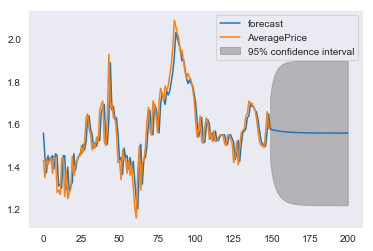

In [30]:
results_ARIMA.plot_predict(end=200);

### Decomposing the series

Using the `seasonal_decompose function` from `statsmodels`, we can decompose the time series into its components. 

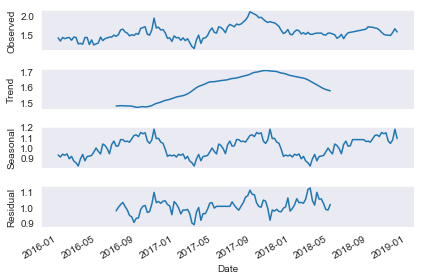

In [31]:
result = seasonal_decompose(organic_df, model='multiplicative',freq=52)
fig = result.plot()

**A seasonal trend is clearly visible.**

### Implementing SARIMAX model

*This is implemented only partially.*

We'll attempt to use the SARIMAX model that accepts the parameters `(p,d,q)` which are the same as ARIMA, and also the additional seasonal components `(P,D,Q,m)`.

The parameters used in the implementation below were obtained by running the `GridSearch.py` program, located in `data/Organic/GridSearch`. 

In [32]:
sarimaxmod = sm.tsa.statespace.SARIMAX(organic_df['AveragePrice'],
                                order=(2, 1, 2), #Same as the optimal obtained
                                seasonal_order=(1, 0, 0, 52), #52 weeks in one year
                                enforce_stationarity=False,
                                enforce_invertibility=False)

SARIMAX_results = sarimaxmod.fit()

SARIMAX_predictions = SARIMAX_results.predict()

SARIMAX_preds = pd.DataFrame(list(zip(list(SARIMAX_predictions.index),list(SARIMAX_predictions))),
                             columns=['Date','PredictedPrice']).set_index('Date')

SARIMAX_predicted_df = pd.merge(organic_df[1:], SARIMAX_preds, left_index=True, right_index=True)
SARIMAX_predicted_df.tail()

,AveragePrice,PredictedPrice
Date,,
2018-11-04,1.500,1.511807
2018-11-11,1.490,1.502946
2018-11-18,1.565,1.489665
2018-11-25,1.660,1.562853
2018-12-02,1.580,1.640387


### Calculating Errors for SARIMAX

In [33]:
print("\tMSE:", mean_squared_error(SARIMAX_predicted_df['AveragePrice'], 
                                                  SARIMAX_predicted_df['PredictedPrice']))
print("\tRMSE:", np.sqrt(mean_squared_error(SARIMAX_predicted_df['AveragePrice'], 
                                                               SARIMAX_predicted_df['PredictedPrice'])))


	MSE: 0.007939576166187817
	RMSE: 0.08910429936982736


### Forecasting for the future, and printing forecasted prices

In [34]:
SARIMAX_forecast = pd.DataFrame(SARIMAX_results.forecast(steps = 40), columns = ['Forecasted Price'])

In [35]:
forecasted_dates = pd.date_range(start='2018-12-09', periods=40,freq='W')
SARIMAX_forecast.insert(0,'Date',forecasted_dates)
SARIMAX_forecast.set_index('Date',inplace=True)

In [36]:
print(SARIMAX_forecast)

            Forecasted Price
Date                        
2018-12-09          1.563363
2018-12-16          1.586464
2018-12-23          1.595287
2018-12-30          1.588946
2019-01-06          1.588440
2019-01-13          1.591655
2019-01-20          1.590717
2019-01-27          1.592737
2019-02-03          1.592503
2019-02-10          1.590737
2019-02-17          1.589690
2019-02-24          1.589982
2019-03-03          1.592447
2019-03-10          1.591638
2019-03-17          1.592963
2019-03-24          1.591293
2019-03-31          1.592878
2019-04-07          1.592907
2019-04-14          1.592274
2019-04-21          1.591940
2019-04-28          1.591937
2019-05-05          1.591943
2019-05-12          1.593227
2019-05-19          1.593545
2019-05-26          1.591941
2019-06-02          1.591942
2019-06-09          1.592584
2019-06-16          1.593224
2019-06-23          1.596110
2019-06-30          1.595149
2019-07-07          1.592904
2019-07-14          1.596431
2019-07-21    

## References
https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/
https://towardsdatascience.com/forecasting-exchange-rates-using-arima-in-python-f032f313fc56